In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('default')

## Importa dati divisi per fasce d'età
Report del 15 Settembre, https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_15-settembre-2021.pdf
I dati si riferiscono ai 30 giorni precedenti

In [2]:
df_età = pd.read_csv('../dati/data_iss_età_2021-09-22.csv', sep=';')

df_età

,età,non vaccinati,vaccinati completo,casi non vaccinati,casi vaccinati,ospedalizzati non vaccinati,ospedalizzati vaccinati,terapia intensiva non vaccinati,terapia intensiva vaccinati,decessi non vaccinati,decessi vaccinati
0,12-39,6122626,8113419,49207,11040,1646,118,76,4,13,2
1,40-59,4469554,12596107,26851,16128,2539,304,300,17,127,16
2,60-79,1705446,11445197,8275,11646,1883,827,355,95,399,127
3,80+,283500,4177484,1800,5236,714,1207,44,57,338,364


## Elaborazione dati

In [3]:
# ricava i tassi, dividendo per la popolazione vaccinati e non vaccinata
tassi = (7/30)*10**5*np.transpose([df_età['casi non vaccinati']/df_età['non vaccinati'],
         df_età['casi vaccinati']/df_età['vaccinati completo'],                  
         df_età['ospedalizzati non vaccinati']/df_età['non vaccinati'],
         df_età['ospedalizzati vaccinati']/df_età['vaccinati completo'],
         df_età['terapia intensiva non vaccinati']/df_età['non vaccinati'],
         df_età['terapia intensiva vaccinati']/df_età['vaccinati completo'],
         df_età['decessi non vaccinati']/df_età['non vaccinati'],
         df_età['decessi vaccinati']/df_età['vaccinati completo']])


df_tassi = pd.DataFrame(tassi)
df_tassi.columns = ['Casi, non vaccinati',
                    'Casi, vaccinati',
                    'Ospedalizzati, non vaccinati', 
                    'Ospedalizzati, vaccinati',
                    'In terapia intensiva, non vaccinati',
                    'In terapia intensiva, vaccinati',
                    'Deceduti, non vaccinati',
                    'Deceduti, vaccinati']

df_tassi.index = df_età['età']

df_tassi

,"Casi, non vaccinati","Casi, vaccinati","Ospedalizzati, non vaccinati","Ospedalizzati, vaccinati","In terapia intensiva, non vaccinati","In terapia intensiva, vaccinati","Deceduti, non vaccinati","Deceduti, vaccinati"
età,,,,,,,,
12-39,187.527922,31.749870,6.272908,0.339355,0.289636,0.011504,0.049543,0.005752
40-59,140.175806,29.875897,13.254865,0.563137,1.566152,0.031491,0.663004,0.029639
60-79,113.215741,23.742711,25.762567,1.686006,4.856990,0.193677,5.458983,0.258915
80+,148.148148,29.245674,58.765432,6.741697,3.621399,0.318373,27.818930,2.033122


## Rappresentazione grafica dei risultati

In [4]:
def which_axe(x):
    axes[x].set_ylabel('Ogni 100.000 persone per ciascun gruppo')
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].legend(['Non vaccinati', 'Vaccinati'])
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)
        
def add_watermark(x):
    axes[x].text(0.5, 0.45, 'Credit: github/apalladi/covid_monitoraggio_vaccini', transform=axes[x].transAxes,
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45)    

### Tassi di contagio

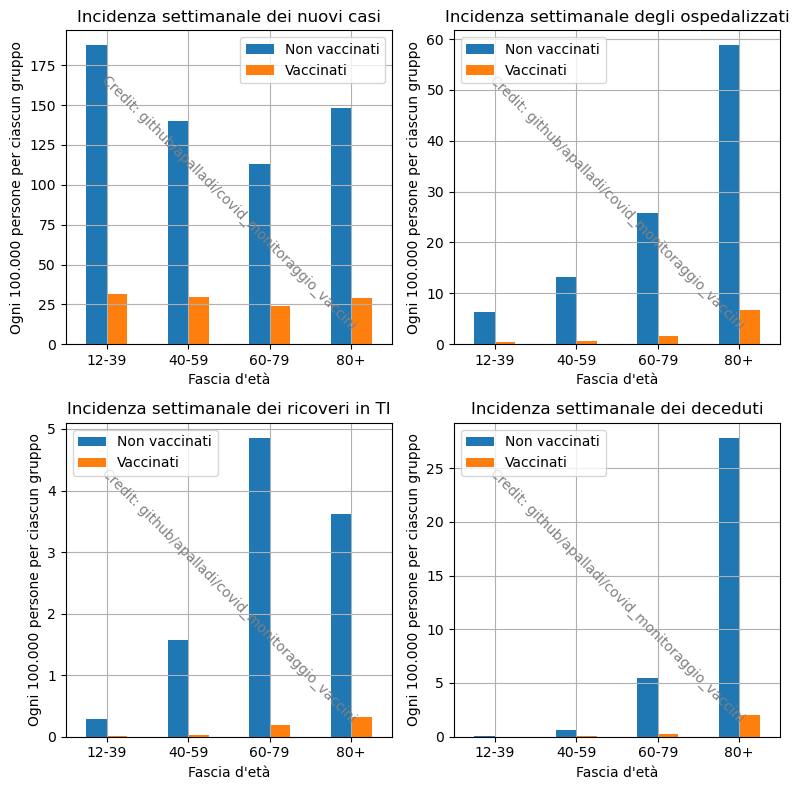

In [5]:
fig, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)
add_watermark(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)
add_watermark(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)
add_watermark(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)
add_watermark(3)

plt.tight_layout()
plt.savefig('../risultati/tassi_per_età.png', dpi=300)
plt.show()

### Efficacia dei vaccini

In [6]:
efficacia_contagio = (1 - df_tassi.iloc[:, 1]/df_tassi.iloc[:, 0])*100
efficacia_osp = (1 - df_tassi.iloc[:, 3]/df_tassi.iloc[:, 2])*100
efficacia_terint = (1 - df_tassi.iloc[:, 5]/df_tassi.iloc[:, 4])*100
efficacia_decessi = (1 - df_tassi.iloc[:, 7]/df_tassi.iloc[:, 6])*100

In [7]:
def add_to_plot():
    plt.ylim(70, 100)
    plt.grid()
    plt.xlabel('Fascia d\'età')
    plt.yticks(np.arange(70, 101, 5), ['70%', '75%', '80%', '85%', '90%', '95%', '100%'])

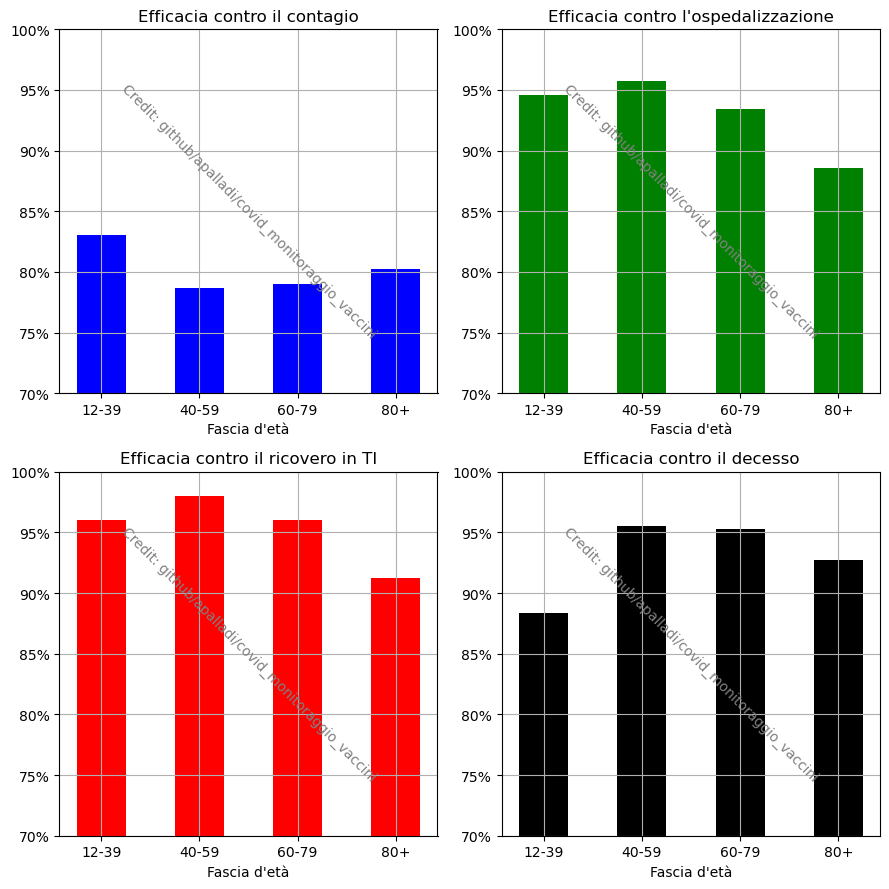

In [8]:
plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.bar(efficacia_contagio.index, efficacia_contagio, color='blue', width=0.5)
plt.title('Efficacia contro il contagio')
plt.text(1.5, 85, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 
add_to_plot()

plt.subplot(2, 2, 2)
plt.bar(efficacia_osp.index, efficacia_osp, color='green', width=0.5)
plt.title('Efficacia contro l\'ospedalizzazione')
plt.text(1.5, 85, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 
add_to_plot()

plt.subplot(2, 2, 3)
plt.bar(efficacia_terint.index, efficacia_terint, color='red', width=0.5)
plt.title('Efficacia contro il ricovero in TI')
plt.text(1.5, 85, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 
add_to_plot()

plt.subplot(2, 2, 4)
plt.bar(efficacia_decessi.index, efficacia_decessi, color='black', width=0.5)
plt.title('Efficacia contro il decesso')
plt.text(1.5, 85, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 
add_to_plot()

plt.tight_layout()
plt.savefig('../risultati/efficacia_vaccini.png', dpi=300)
plt.show()

### Grafico riassuntivo

In [9]:
def which_axe_bar(x):
    axes[x].set_ylim(80, 100)
    axes[x].set_yticks(np.arange(70, 101, 5))
    axes[x].set_yticklabels(['70%', '75%', '80%', '85%', '90%', '95%', '100%'])
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)


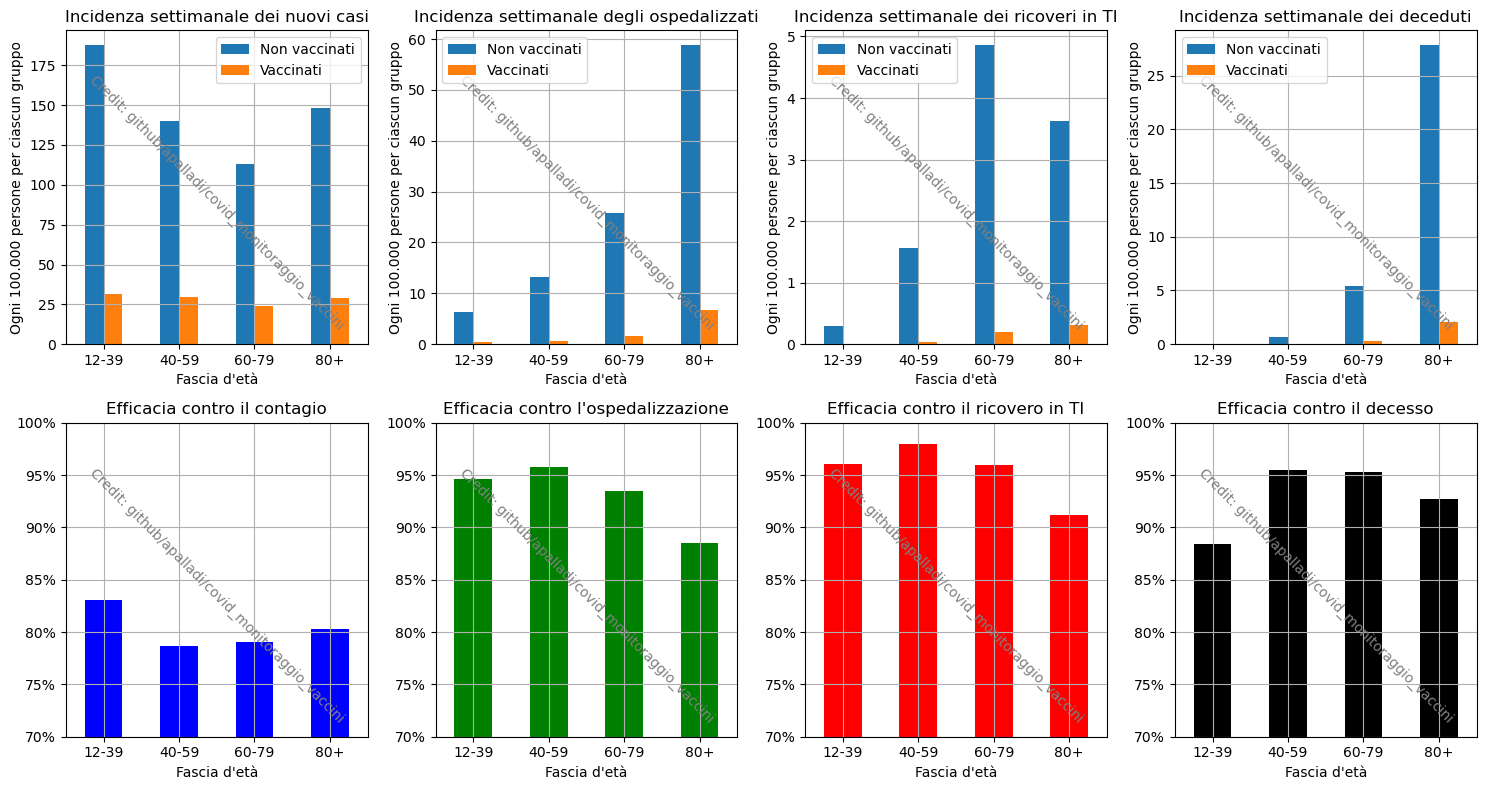

In [10]:
fig, axes2 = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)
add_watermark(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)
add_watermark(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)
add_watermark(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)
add_watermark(3)

efficacia_contagio.plot(kind='bar', ax=axes[4], color='blue')
axes[4].set_title('Efficacia contro il contagio')
which_axe_bar(4)
add_watermark(4)

efficacia_osp.plot(kind='bar', ax=axes[5], color='green')
axes[5].set_title('Efficacia contro l\'ospedalizzazione')
which_axe_bar(5)
add_watermark(5)

efficacia_terint.plot(kind='bar', ax=axes[6], color='red')
axes[6].set_title('Efficacia contro il ricovero in TI')
which_axe_bar(6)
add_watermark(6)

efficacia_decessi.plot(kind='bar', ax=axes[7], color='black')
axes[7].set_title('Efficacia contro il decesso')
which_axe_bar(7)
add_watermark(7)

plt.tight_layout()
plt.savefig('../risultati/tassi_efficacia.png', dpi=300)
plt.show()

### Focus sugli over 60

In [11]:
df_over60 = df_età.loc[[2,3], ['non vaccinati', 'vaccinati completo', 
                'terapia intensiva non vaccinati', 'terapia intensiva vaccinati',
                'decessi non vaccinati', 'decessi vaccinati']].sum()

df_over60

non vaccinati                       1988946
vaccinati completo                 15622681
terapia intensiva non vaccinati         399
terapia intensiva vaccinati             152
decessi non vaccinati                   737
decessi vaccinati                       491
dtype: int64

In [12]:
over60_array = np.array(df_over60)

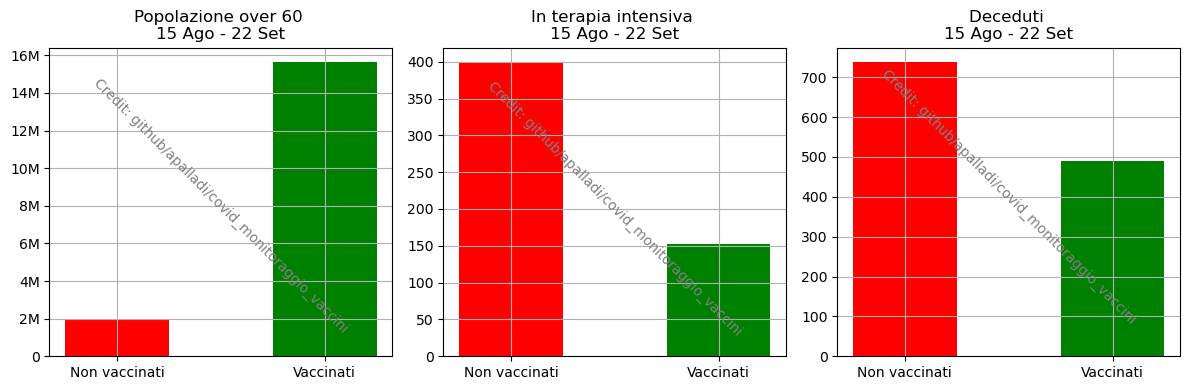

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(0, over60_array[0], width=0.5, color='red')
plt.bar(1, over60_array[1], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.yticks(10**6*np.arange(0, 17, 2), ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M'])
plt.grid()
plt.title('Popolazione over 60 \n15 Ago - 22 Set')
plt.text(0.5, 8e6, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 

plt.subplot(1, 3, 2)
plt.bar(0, over60_array[2], width=0.5, color='red')
plt.bar(1, over60_array[3], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title('In terapia intensiva \n15 Ago - 22 Set')
plt.text(0.5, 200, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 

plt.subplot(1, 3, 3)
plt.bar(0, over60_array[4], width=0.5, color='red')
plt.bar(1, over60_array[5], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title('Deceduti \n15 Ago - 22 Set')
plt.text(0.5, 400, 'Credit: github/apalladi/covid_monitoraggio_vaccini',
        fontsize=10, color='grey', alpha=1,
        ha='center', va='center', rotation=-45) 

plt.tight_layout()
plt.savefig('../risultati/focus_over60.png', dpi=300)
plt.show()

In [14]:
ratio_vacc_novacc = round(over60_array[1]/over60_array[0], 1)
ratio_terint = round(over60_array[2]/over60_array[3], 1)
ratio_dec = round(over60_array[4]/over60_array[5], 1)

print('Rapporto tra vaccinati e non vaccinati', ratio_vacc_novacc)
print('Rapporto tra ricoverati in terapia intensiva (novacc/vacc)', ratio_terint)
print('Rapporto tra deceduti (novacc/vacc)', ratio_dec)

Rapporto tra vaccinati e non vaccinati 7.9
Rapporto tra ricoverati in terapia intensiva (novacc/vacc) 2.6
Rapporto tra deceduti (novacc/vacc) 1.5


In [15]:
print('Peso sul sistema sanitario di un non vaccinato over 60:', ratio_vacc_novacc*ratio_terint)
print('Peso sulla mortalità di un non vaccinato over 60:      ', ratio_vacc_novacc*ratio_dec)

Peso sul sistema sanitario di un non vaccinato over 60: 20.540000000000003
Peso sulla mortalità di un non vaccinato over 60:       11.850000000000001
